# Что и зачем 
Хочу как минимум иметь актуальную статистику по коронавирусу. Как максимум - попытаться спрогнозировать 
продолжительность и массовой эпидемии и карантина (хочу отметить майские праздники)

### Откуда данные

Данные взяты [отсюда](https://github.com/CSSEGISandData/COVID-19) 
(соответствуют данным ВОЗ, но очень удобно скомпанованы в CSV по дням).

Обновляются ежедневно, как отмечает автор, в 23:59 UTC. По Москве это в 02:59 ночи. Точность не проверл.

Сами данные тоже местами странноватые: есть взять начало марта и посмотреть на РФ, то мы увидим падение кол-ва 
зарегистрированных случаев коронавируса (09.03 - 10.03). Но в остальном похожи на правду.

Далее немного костылей, которые в первую очередь связаны со временам и с запаздыванием в датах: данные есть только за 
прошедши день.
Даты решил хранить в глобальной переменной, хуже от этого никому не будет.

In [1]:
import requests
from datetime import datetime, timedelta

# global dates
dates = [(datetime.today() - timedelta(days=i)).date() for i in range(1, 32)]
dates.sort()
r = requests.get(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                 f'csse_covid_19_daily_reports/{dates[-1].strftime("%m-%d-%Y")}.csv')
if r.status_code == 404:
    dates.pop()

Ниже описанны классы данных. 

Класс `Day` для хранения информации по одному дню. На текущий момент времени в него суммируется все данные за день 
(например, если будут данные за несколько субъектов гос-ва, как в Китае, данные посчитаются просто как сумма). 
Это не совсем правильно, но в приоритете для меня стоит статистика по РФ, где пока разбиения на субъекты не завезли.
Как завезут или как будет время - добавлю класс на эту тему.
Иммет тупейший метод `fetch` - вычисление актуального количества больных за день. Как дойдут руки - перепишу метод,
добавлю в него вычисление 'заразности за день' (ниже подробнее описал).

Класс `Country` - сборная солянка по стране. 
Имеет метод `get_data` - берется глобальная переменная dates и исходя из нее тянутся данные, создаются экземпляры 
класса `Day` и записываются в list.
Второй метод `calc_propagation_trend` - считает среднее арифметическое всех объектов `Day` и пишет в propagation, 
то есть, тренд по распространению (опять же ниже это подробно описано). 
Имеет переменные name и alt_name: название страны в разных файлах может варьироваться (Russia/Russian Federation или 
China/Mainland China).

In [2]:
import pandas as pd
from dataclasses import dataclass, field


@dataclass()
class Day(object):
    date: datetime.date
    confirmed: int = 0
    dead: int = 0
    cured: int = 0
    sick: int = 0
    propagation: int = 1

    def fetch(self):
        self.sick = self.confirmed - self.cured - self.dead


@dataclass()
class Country(object):
    global dates
    name: str
    alt_name: str
    data: list = field(default_factory=lambda: [])
    states: list = field(default_factory=lambda: [])
    propagation_trend: float = 0

    def get_data(self):
        for date in dates:
            day = Day(date=date)
            df = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                             f'csse_covid_19_daily_reports/{date.strftime("%m-%d-%Y")}.csv')

            for _, row in df[(df['Country/Region'] == self.name)
                             | (df['Country/Region'] == self.alt_name)].iterrows():
                day.confirmed += int(row['Confirmed'])
                day.cured += int(row['Recovered'])
                day.dead += int(row['Deaths'])

            day.fetch()
            if self.data:
                try:  # todo ask is it right way
                    day.propagation = 1 + (day.confirmed - self.data[-1].confirmed) / self.data[-1].sick
                except ZeroDivisionError:  # todo change this shit to something else, it's not normal
                    day.propagation = 0

            self.data.append(day)

    def calc_propagation_trend(self):
        trend = 0
        trend_days = 0
        for day in self.data:
            if day.propagation != 0:
                trend += day.propagation
                trend_days += 1

        self.propagation_trend = trend / trend_days


Собственно собираем данные. 

Как дойдут руки - сделаю вывод данных в таблицу, пока что сорре

In [3]:

country = Country(name='Russia', alt_name='Russian Federation')

country.get_data()

Вычисляем и выводим тренд распространения.

### Что за тренд.
Хоть какой-то показатель скорости распространения коронавируса. Считал так:
1. Для начала я вычисляю 'заразность дня', то есть отношение 
> (кол-во подтвержденых случаев сегодня - кол-во подтвержденых случаев вчера) к количеству больных вчера.
2. Средний тренд распространения я считал как среднее арифметическое трендов за все дни наблюдения. 
Как вариант сделать несколько трендов: за неделю/месяц/все время - хз как правильно.

> Подемать насчет время среднего тренда = инкубационный период.

У 'заразности дня' есть ощутимый косяк - например для данных по РФ за конец февраля получается деление на 0 (связано с 
тем: что кол-во диагностированных заболеваний = кол-ву выздоровевших). В тренде распространения дни с этим косяком не 
использовал совсем (это может быть проблемой: так как может повышать тренд).

P.S. Не уверен, что именно так стоит считать заразность.

In [4]:
country.calc_propagation_trend()
print(f'Средний тренд распространения: {country.propagation_trend}')


Средний тренд распространения: 1.516369775343156


### Строим графички

На первом графике все просто: текущая ситуация, кол-во больных/переболевших/мертвых.

На третьем графике соотношение выздоровевших/умерших. Особо ничего не показывает, но мне почему-то показалось важным 
нарисовать такой график.

На втором графике самое интереснок: описанный выше тренд указан красным, синим нарисована 'заразность дня'.

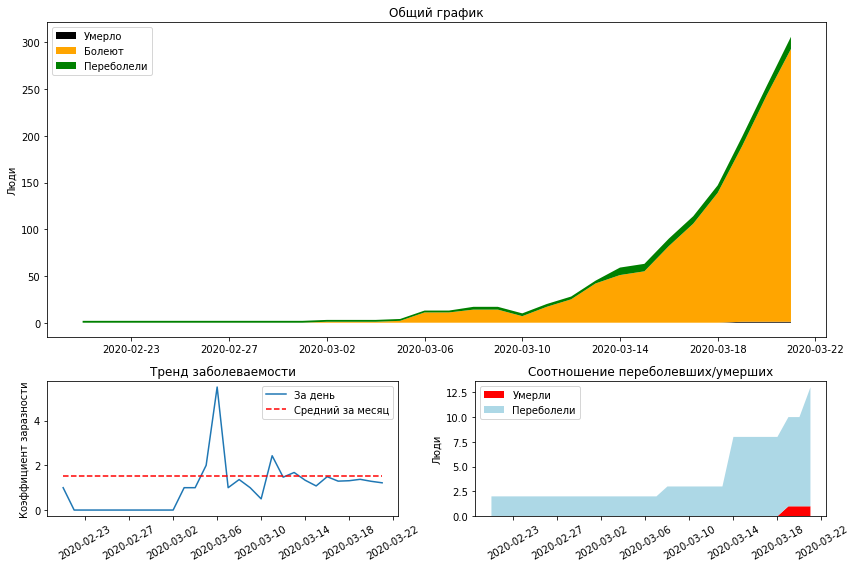

In [5]:
from matplotlib import pyplot as plt


x = tuple(dates)
y1 = [day.dead for day in country.data]
y2 = [day.sick for day in country.data]
y3 = [day.confirmed for day in country.data]
y4 = [day.propagation for day in country.data]
y5 = [country.propagation_trend for i in range(len(country.data))]
y6 = [day.cured for day in country.data]
ticks = [datetime.date(datetime.today() - timedelta(days=i)) for i in range(1, len(dates), 4)]

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))

ax1.fill_between(x, 0, y1, facecolor='black', label='Умерло')
ax1.fill_between(x, y1, y2, facecolor='orange', label='Болеют')
ax1.fill_between(x, y2, y3, facecolor='green', label='Переболели')
ax1.set_title('Общий график')
ax1.legend(loc='upper left')
ax1.set_ylabel('Люди')
ax1.set_xticks(ticks)

ax2.plot(x, y4, label='За день')
ax2.plot(x, y5, 'r--', label='Средний за месяц')
ax2.set_title('Тренд заболеваемости')
ax2.legend(loc='upper right')
ax2.set_ylabel('Коэффициент заразности')
ax2.tick_params(axis='x', rotation=30)
ax2.set_xticks(ticks)

ax3.stackplot(x, y1, y6, labels=['Умерли', 'Переболели'], colors=['red', 'lightblue'])
ax3.set_title('Соотношение переболевших/умерших')
ax3.legend(loc='upper left')
ax3.set_ylabel('Люди')
ax3.tick_params(axis='x', rotation=30)
ax3.set_xticks(ticks)

fig.tight_layout()
plt.show()
